In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [248]:
df = pd.read_csv("/content/Telco-Customer-Churn.csv")

In [249]:
#Veriye ön bakış fonksiyonu
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head())
    print("##################### Tail #####################")
    print(dataframe.tail())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes  

In [250]:
#TotalCharges veri ön bakışta object gözüküyor ancak değerleri sayısaldır. Bu yüzden numerik değere çeviyoruz.
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

#Churn değişkenini 1-0 a dönüştüreceğiz
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

In [251]:
#Churn'un içinde hangi sınıflar var bunları array olarak gösteriyor.
df["Churn"].unique()

array([0, 1])

In [252]:
#Veriye ön bakış fonksiyonu
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes  

TotalCharges değişkenin de galiba aykırı değerler var.

In [253]:
def grab_col_names(dataframe, cat_th=10,car_th=30):

  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat

  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [254]:
print(cat_cols)
print(num_cols)
print(cat_but_car)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Churn']
['tenure', 'MonthlyCharges', 'TotalCharges']
['customerID']


        gender     Ratio
gender                  
Male      3555  50.47565
Female    3488  49.52435
##########################################


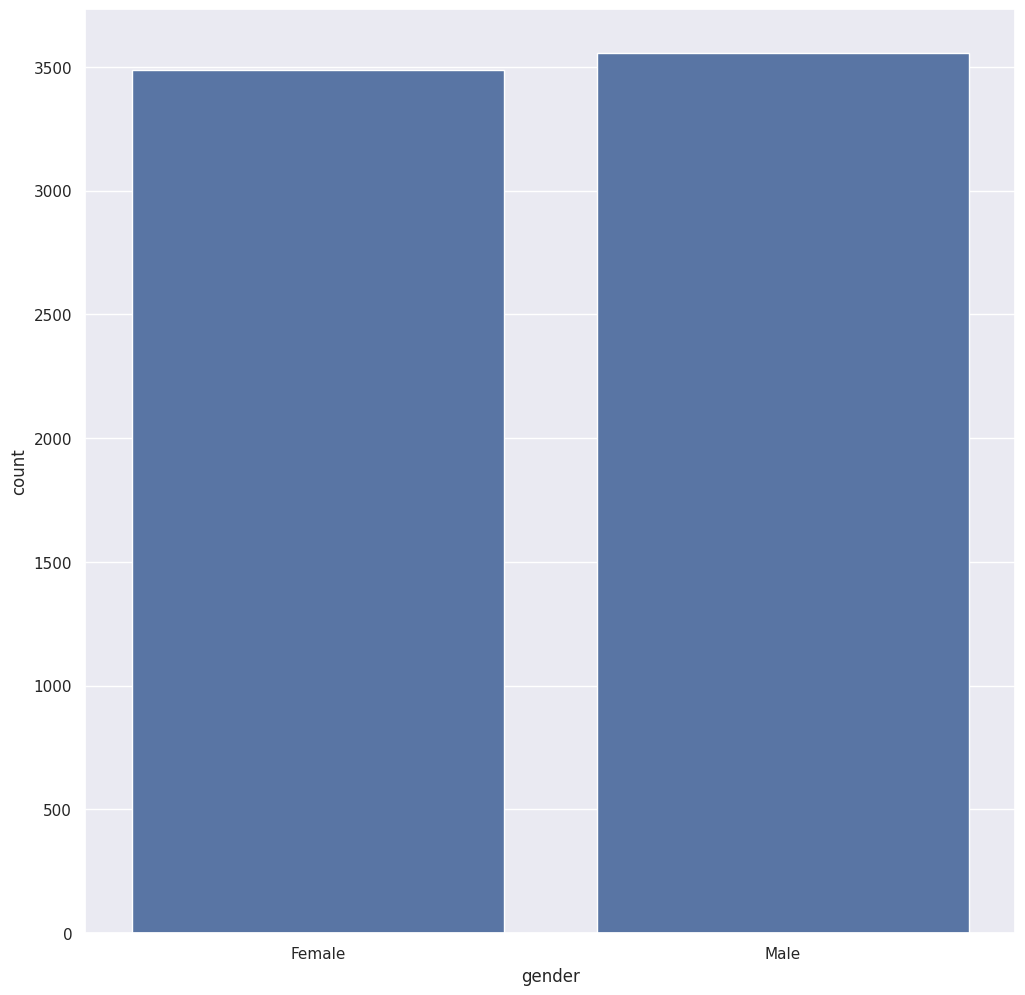

         Partner     Ratio
Partner                   
No          3641  51.69672
Yes         3402  48.30328
##########################################


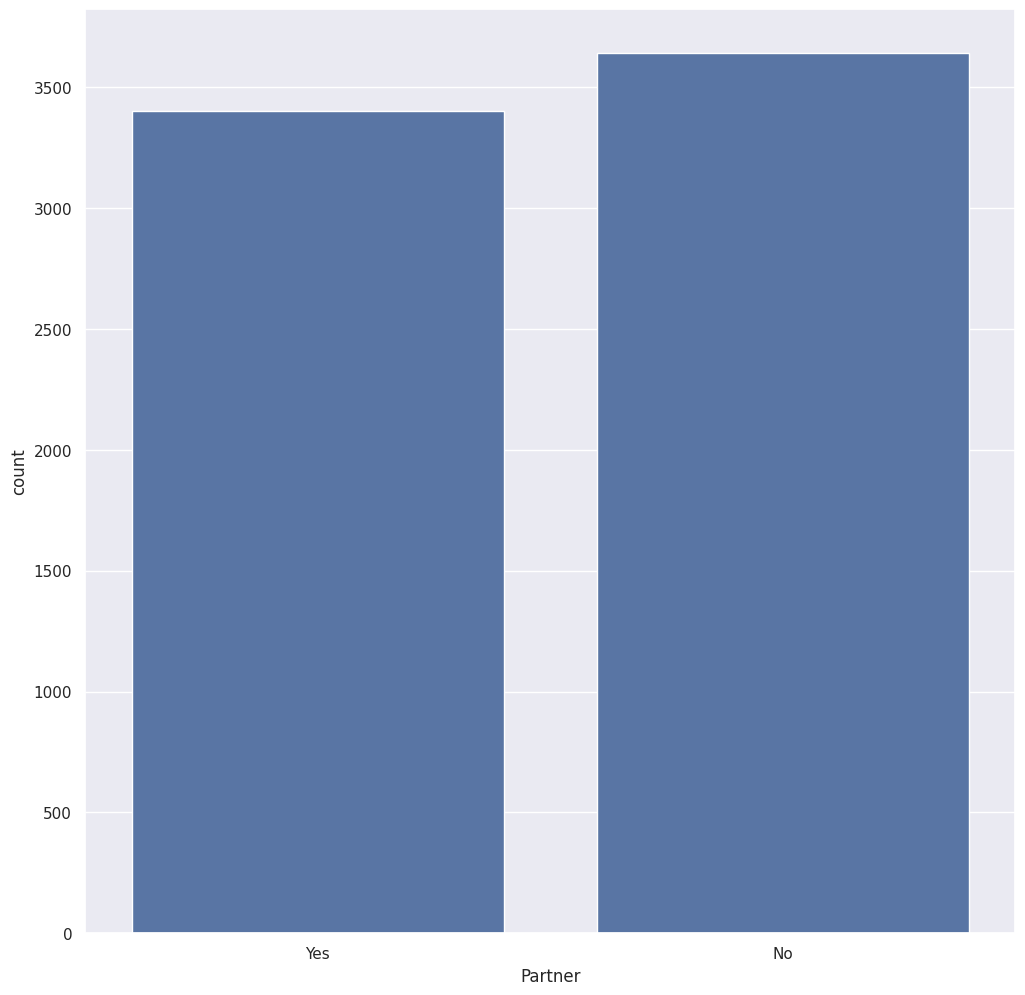

            Dependents      Ratio
Dependents                       
No                4933  70.041176
Yes               2110  29.958824
##########################################


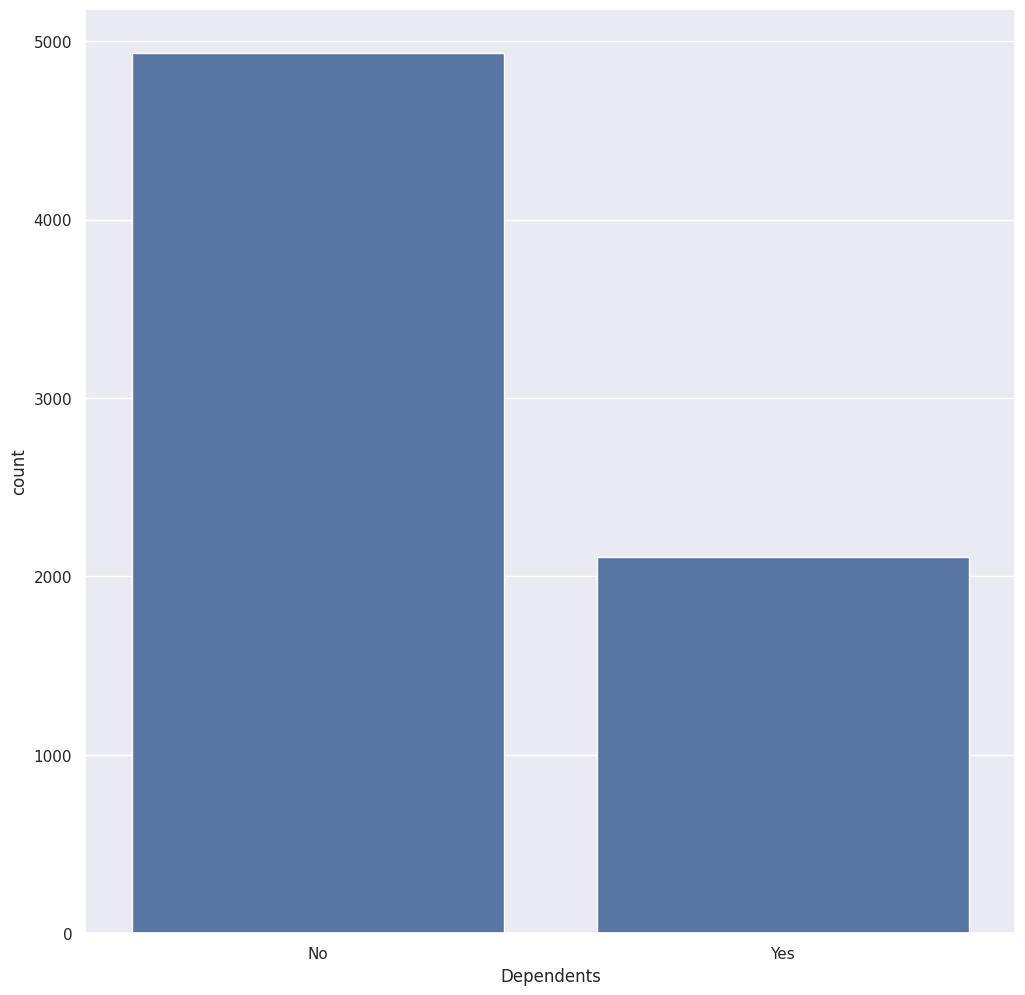

              PhoneService      Ratio
PhoneService                         
Yes                   6361  90.316626
No                     682   9.683374
##########################################


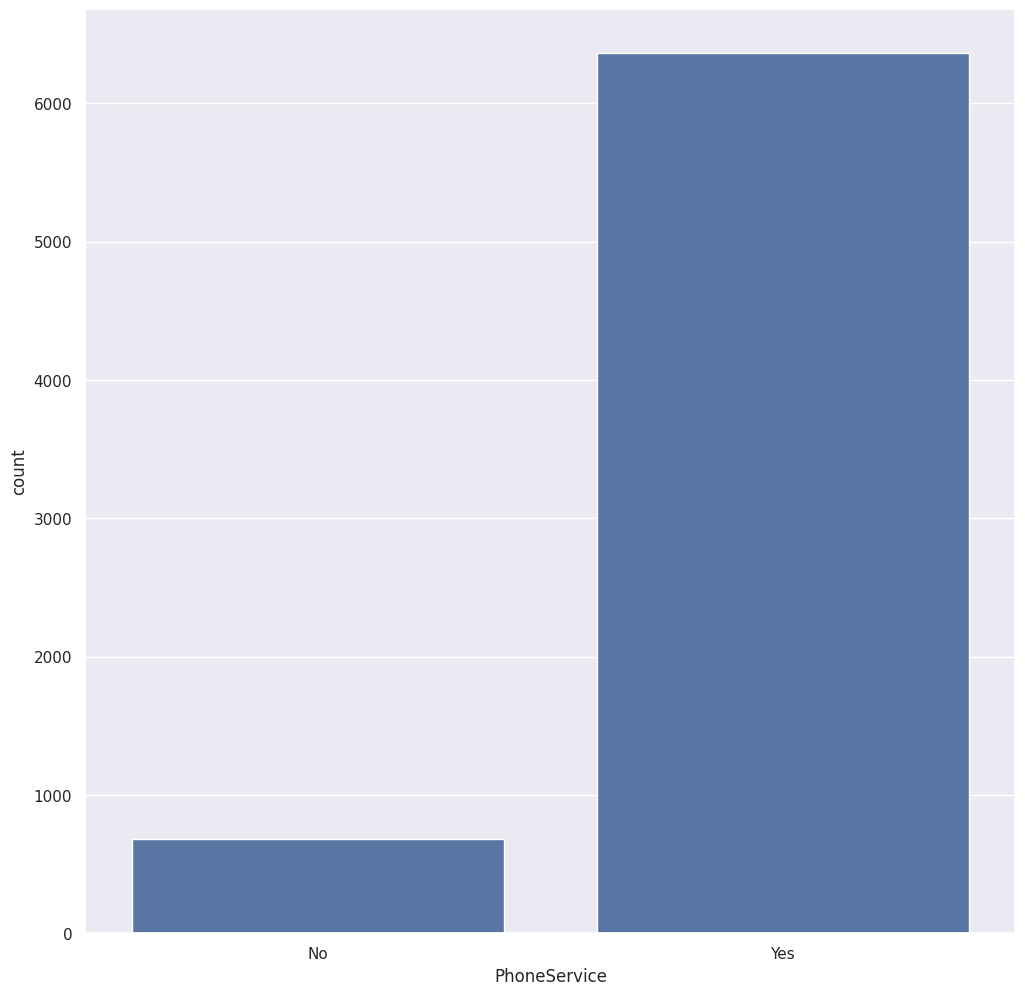

                  MultipleLines      Ratio
MultipleLines                             
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374
##########################################


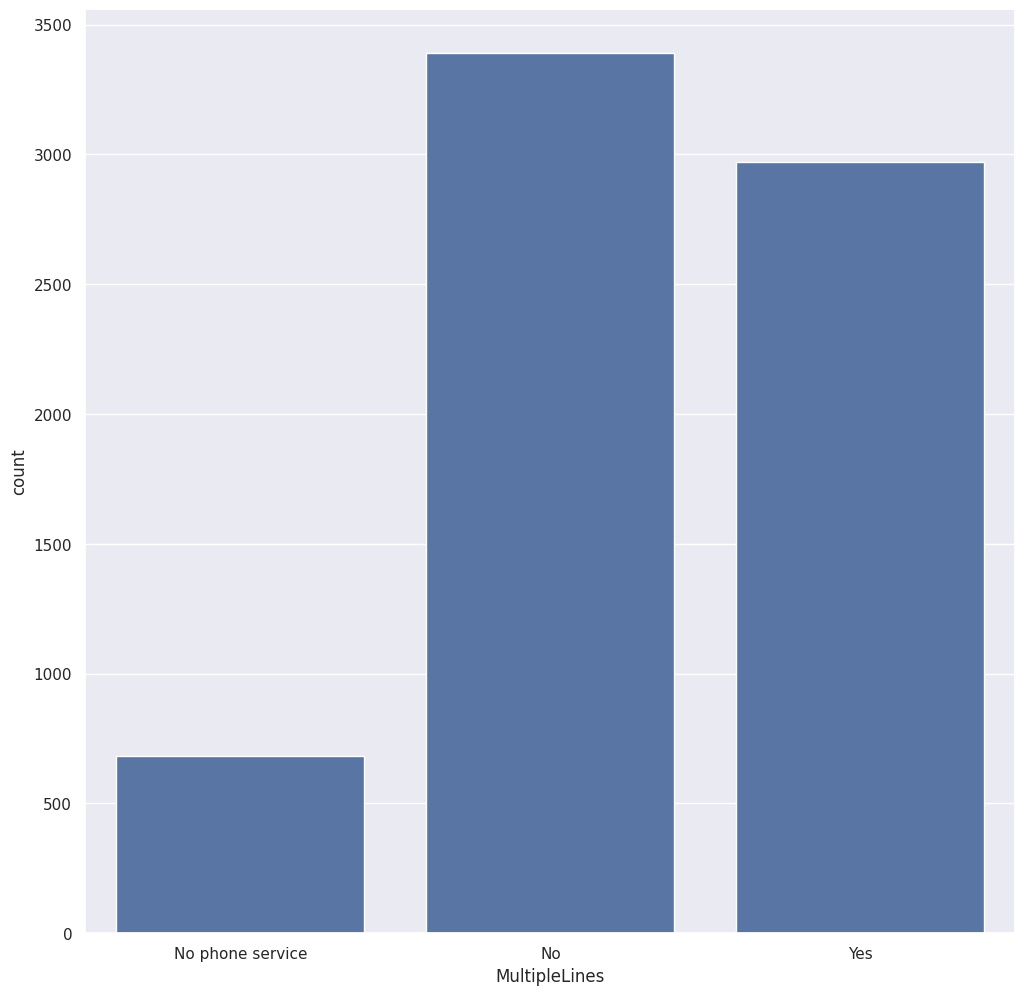

                 InternetService      Ratio
InternetService                            
Fiber optic                 3096  43.958540
DSL                         2421  34.374556
No                          1526  21.666903
##########################################


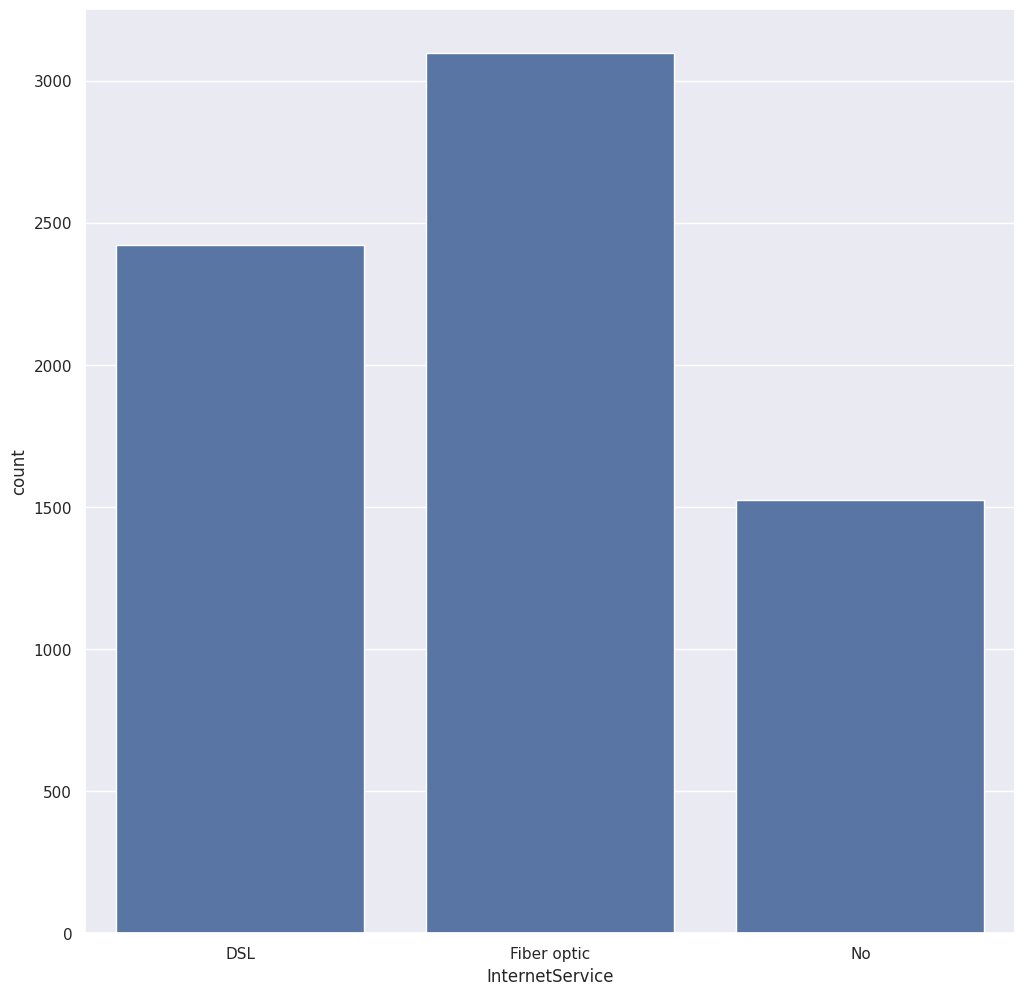

                     OnlineSecurity      Ratio
OnlineSecurity                                
No                             3498  49.666335
Yes                            2019  28.666761
No internet service            1526  21.666903
##########################################


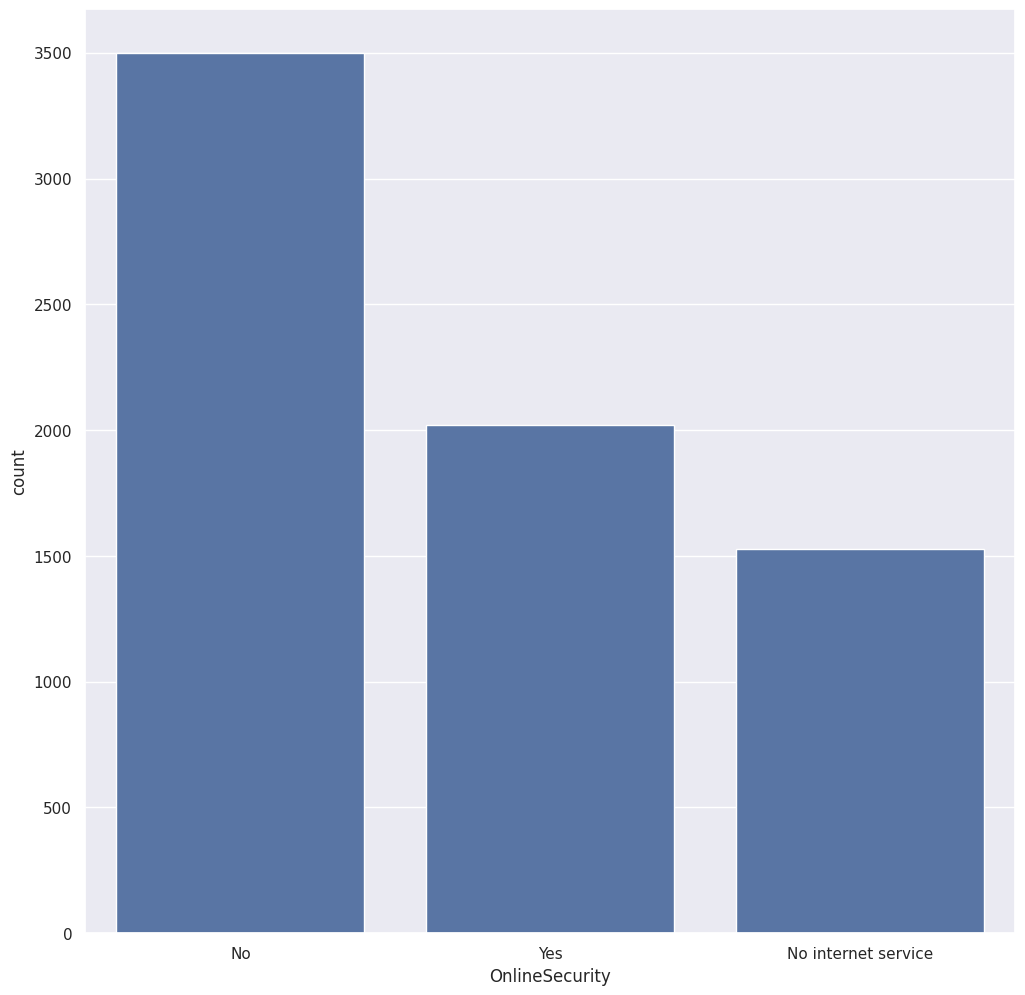

                     OnlineBackup      Ratio
OnlineBackup                                
No                           3088  43.844952
Yes                          2429  34.488144
No internet service          1526  21.666903
##########################################


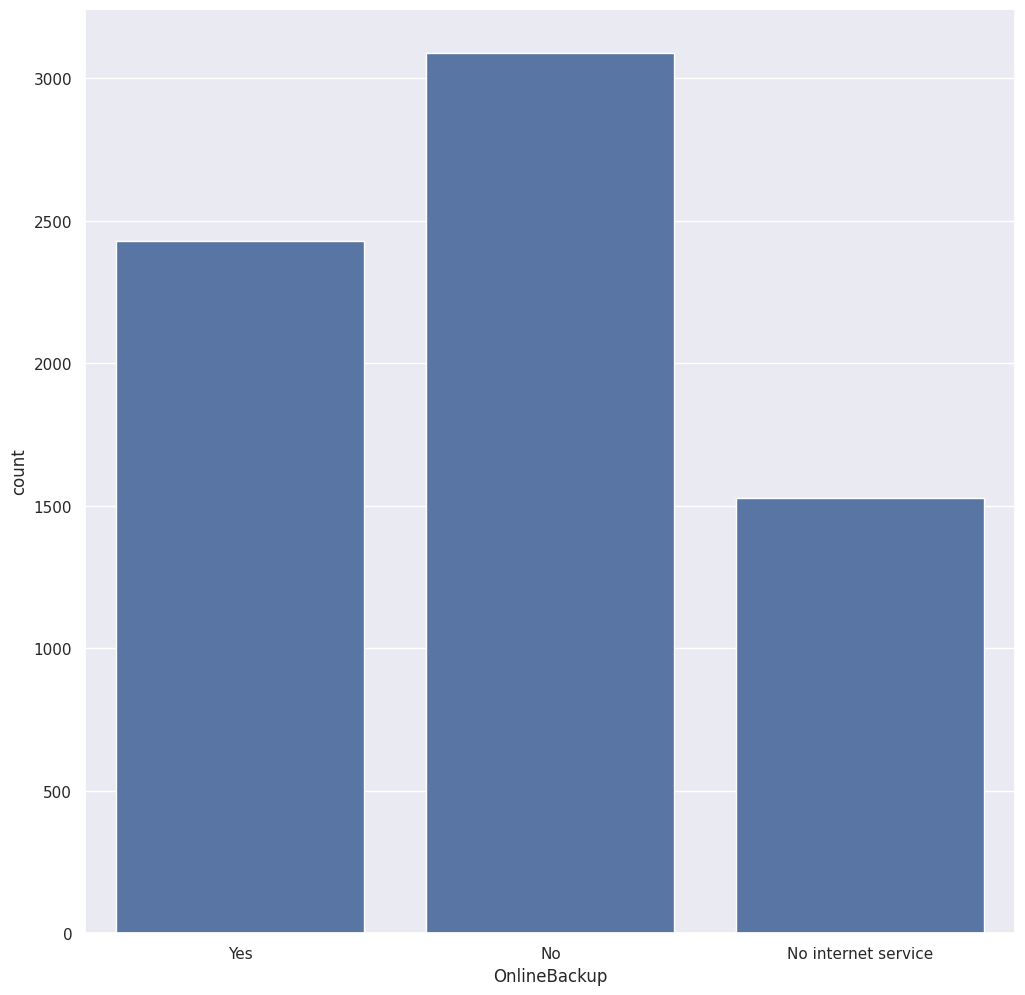

                     DeviceProtection      Ratio
DeviceProtection                                
No                               3095  43.944342
Yes                              2422  34.388755
No internet service              1526  21.666903
##########################################


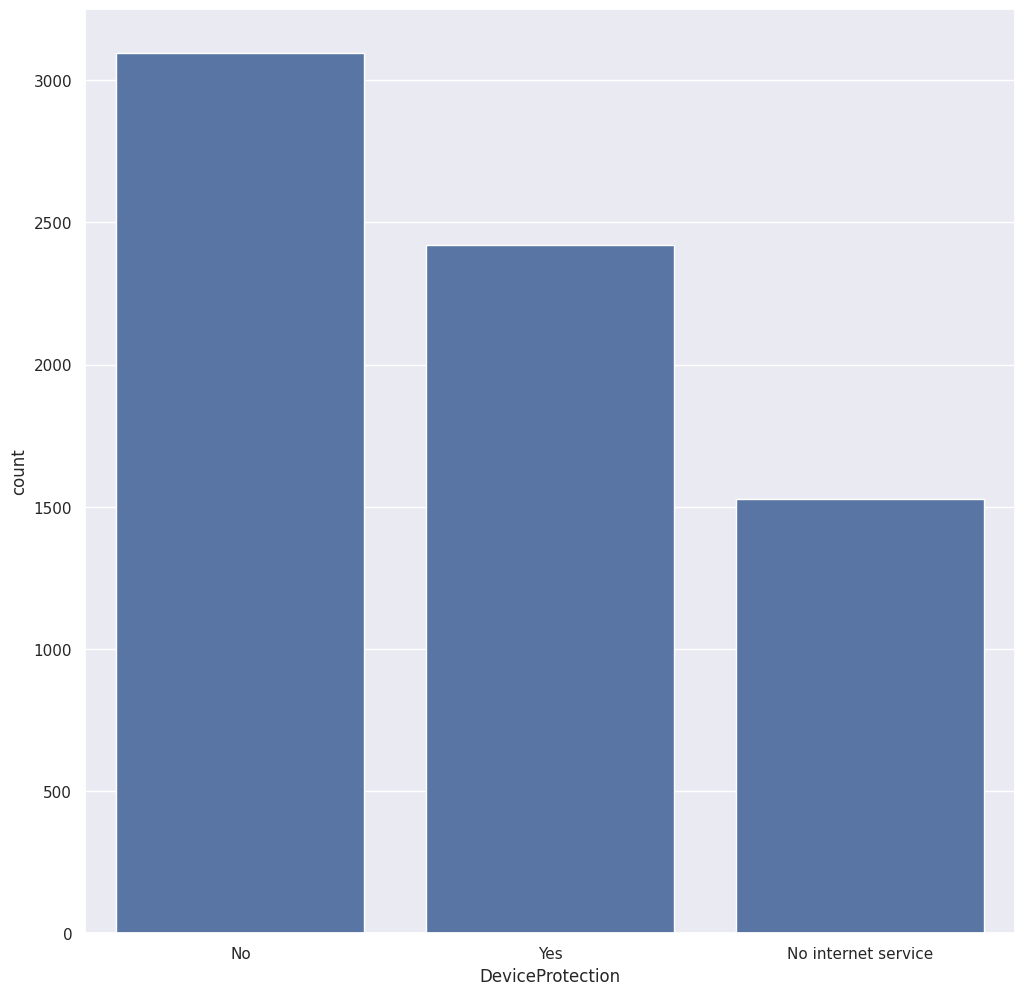

                     TechSupport      Ratio
TechSupport                                
No                          3473  49.311373
Yes                         2044  29.021724
No internet service         1526  21.666903
##########################################


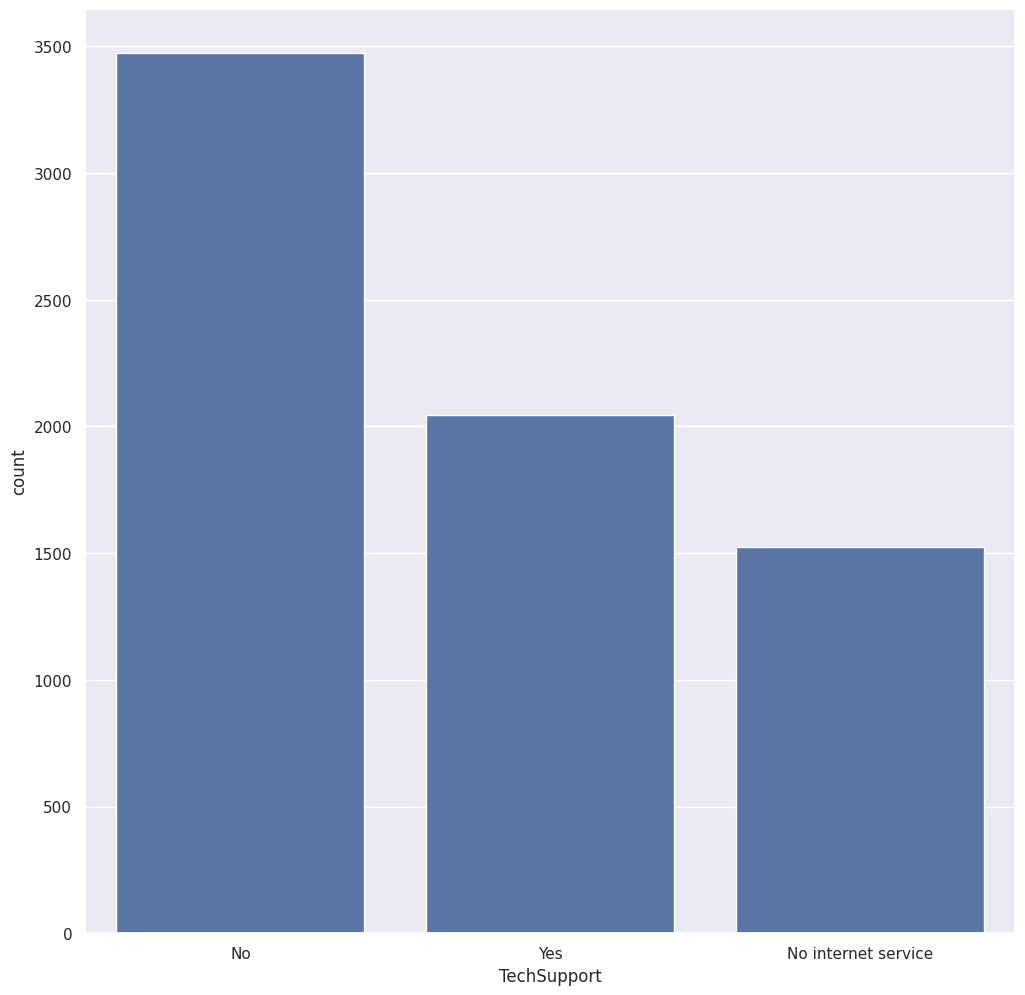

                     StreamingTV      Ratio
StreamingTV                                
No                          2810  39.897771
Yes                         2707  38.435326
No internet service         1526  21.666903
##########################################


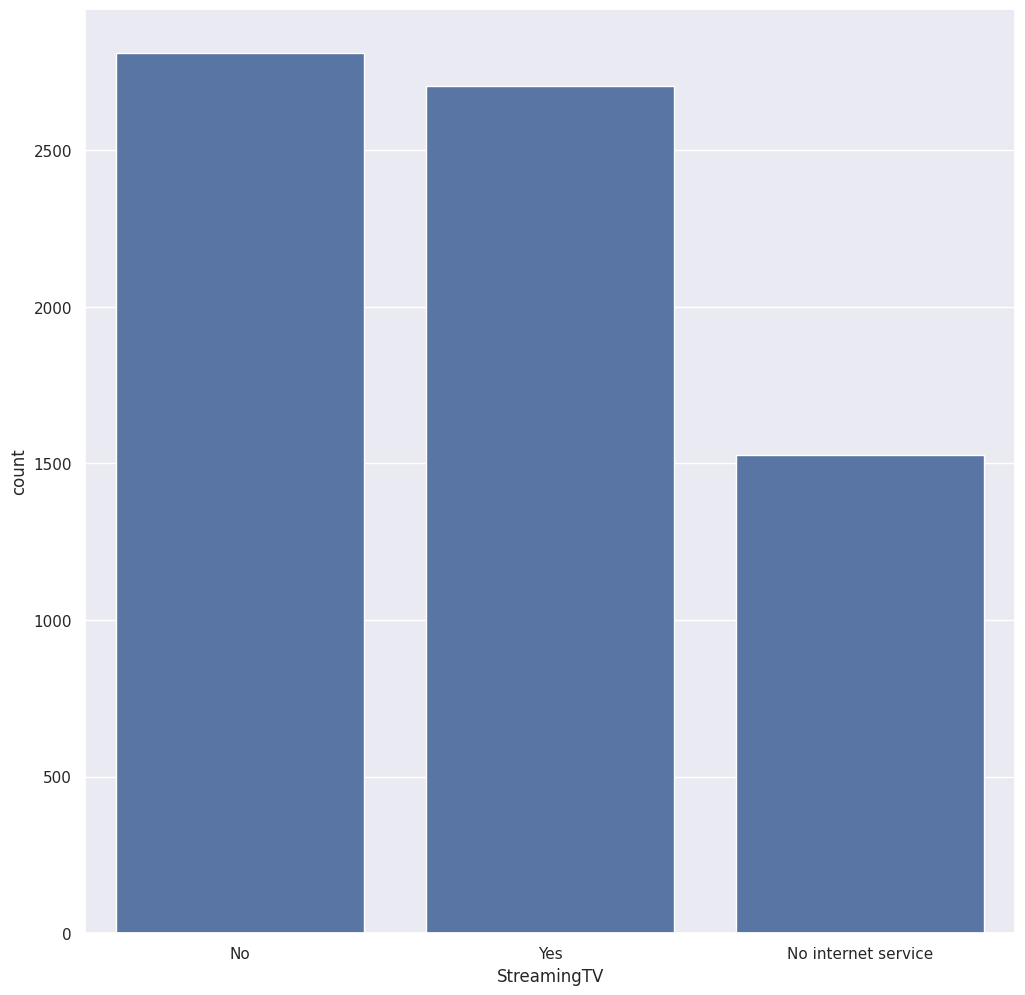

                     StreamingMovies      Ratio
StreamingMovies                                
No                              2785  39.542808
Yes                             2732  38.790288
No internet service             1526  21.666903
##########################################


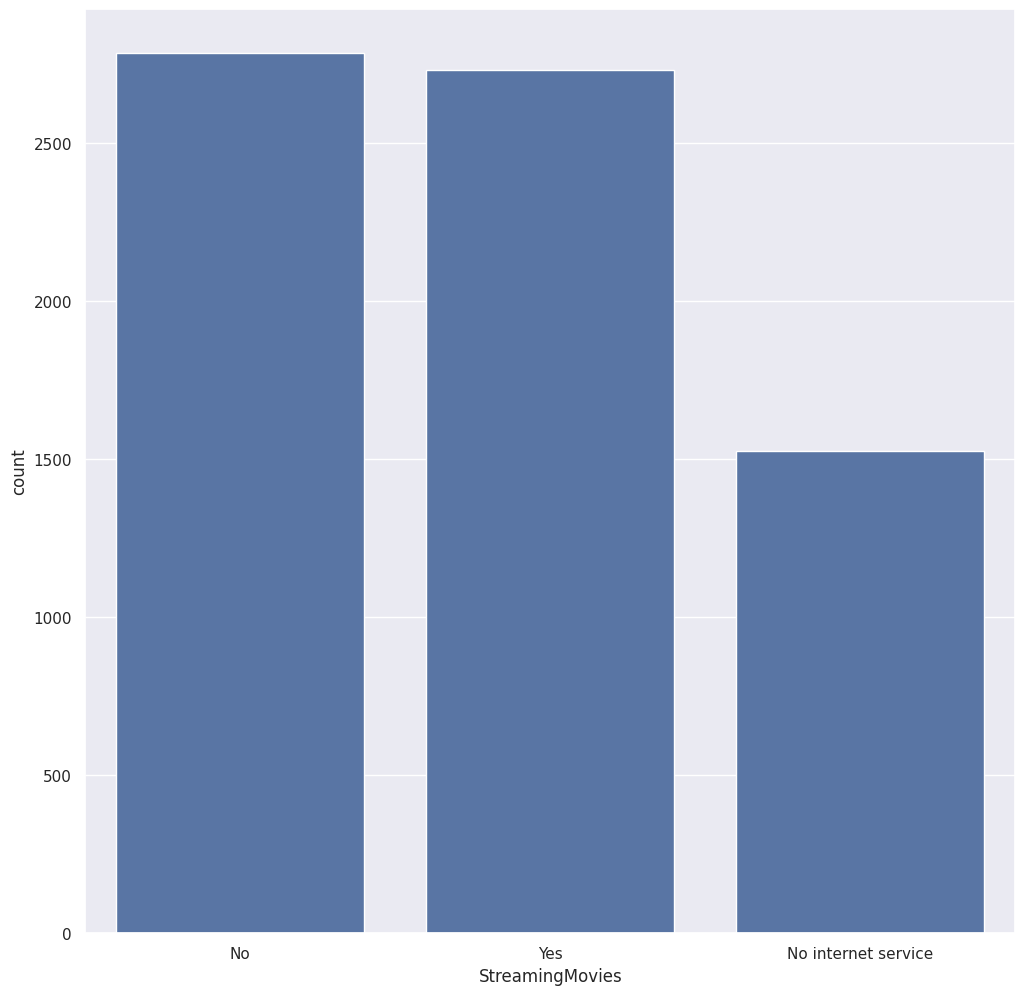

                Contract      Ratio
Contract                           
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383
##########################################


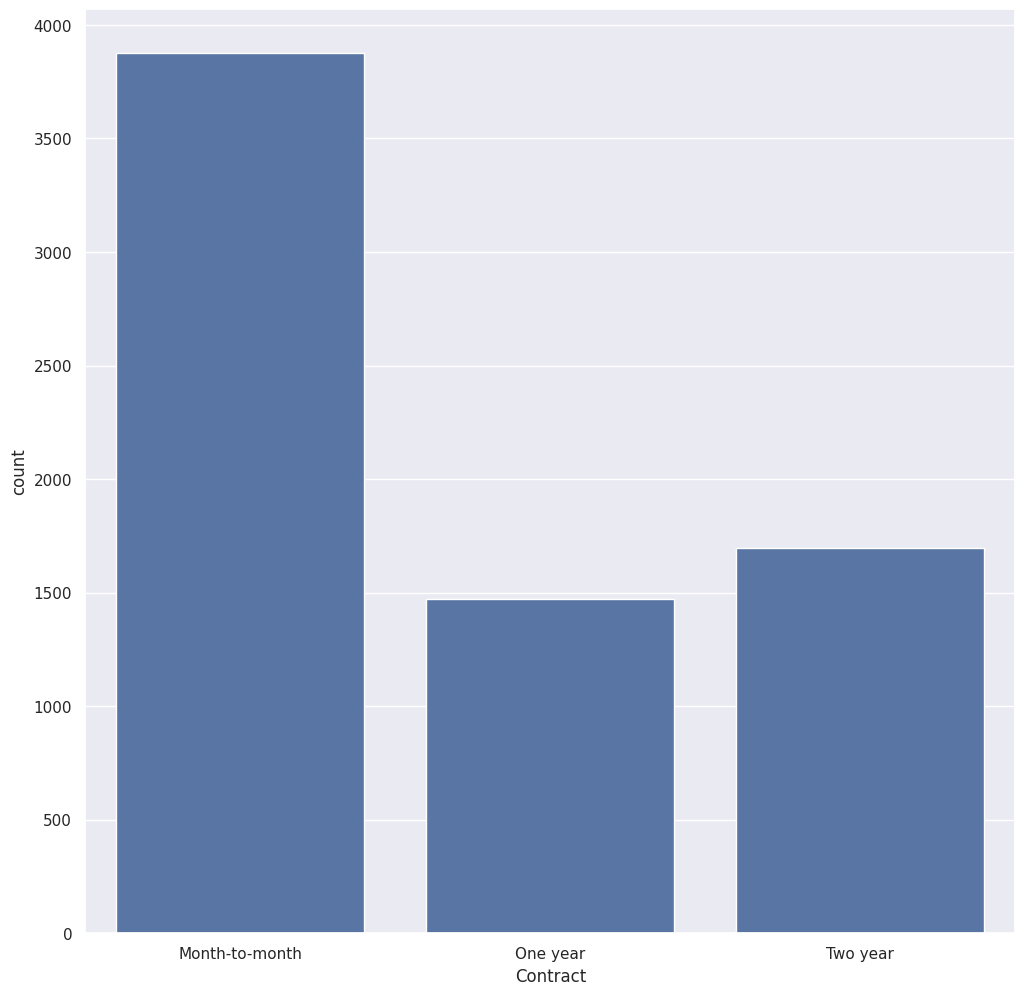

                  PaperlessBilling      Ratio
PaperlessBilling                             
Yes                           4171  59.221922
No                            2872  40.778078
##########################################


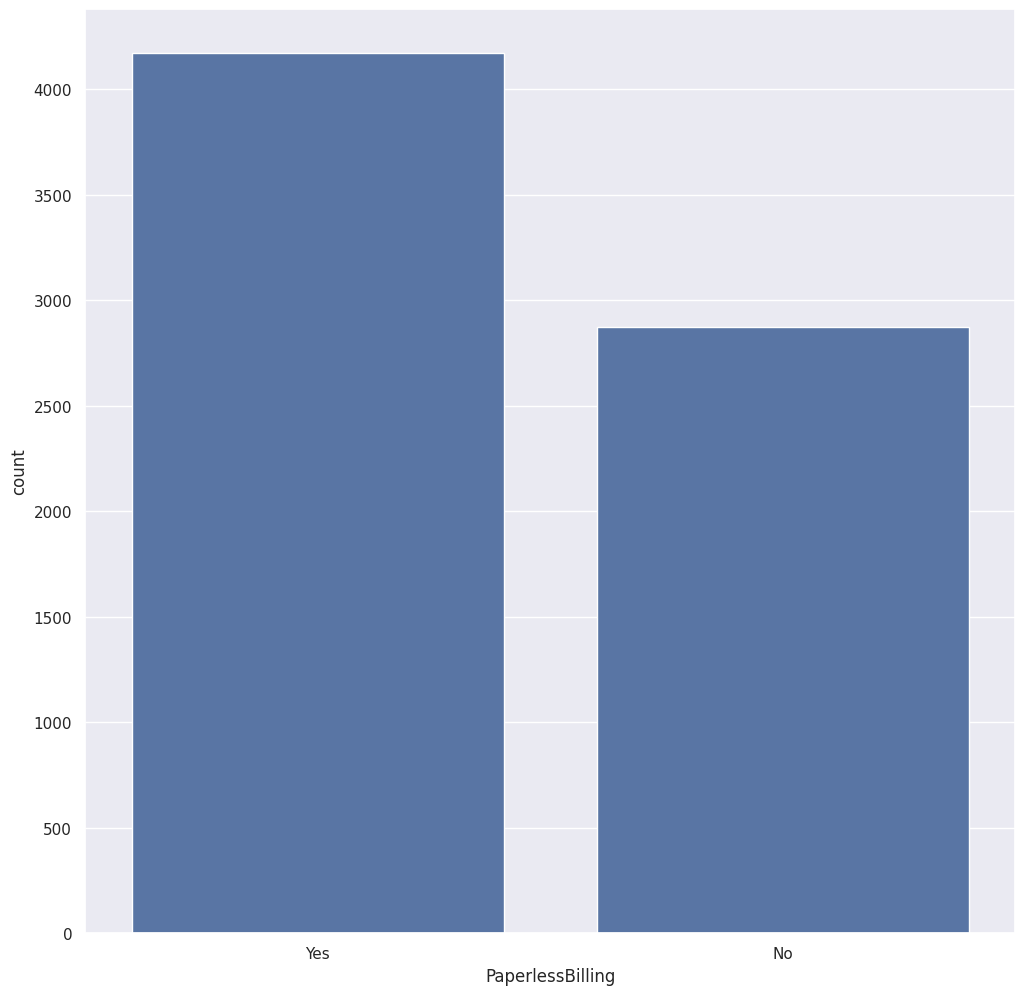

                           PaymentMethod      Ratio
PaymentMethod                                      
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109
##########################################


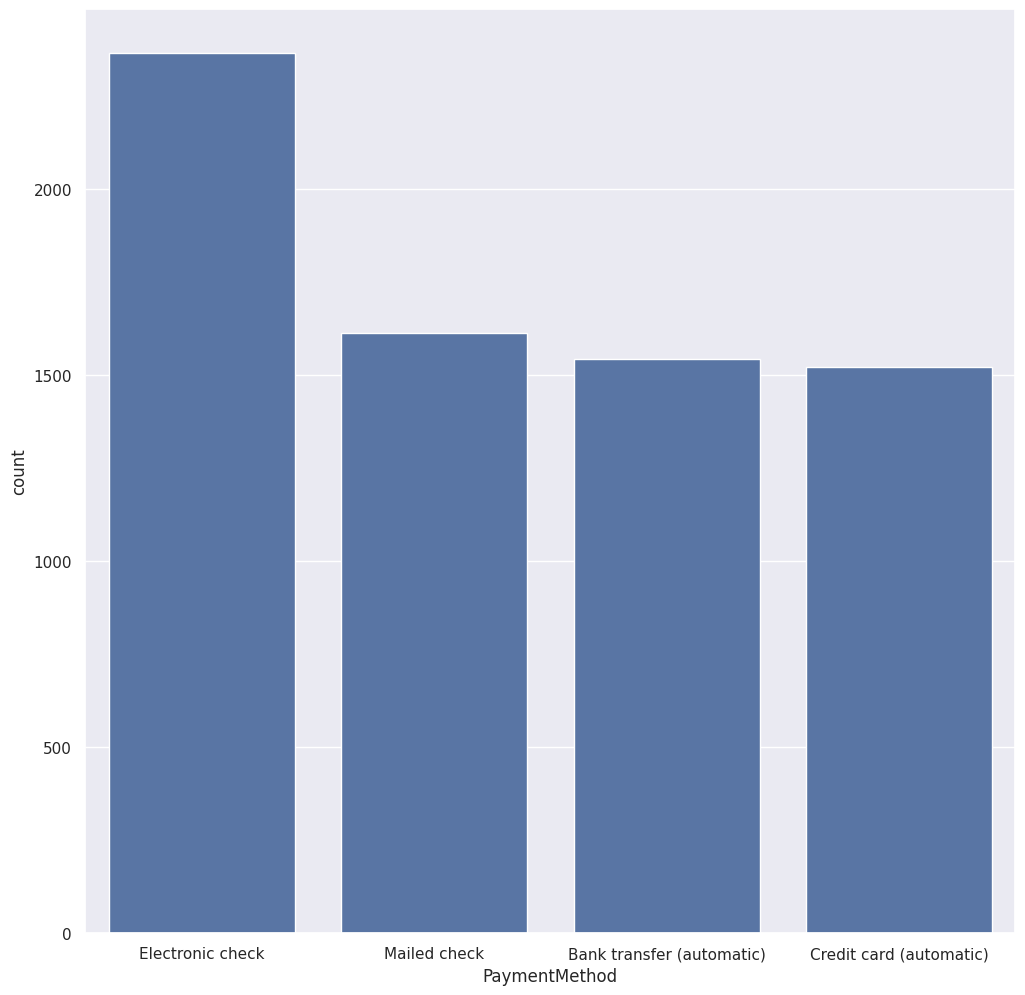

               SeniorCitizen      Ratio
SeniorCitizen                          
0                       5901  83.785319
1                       1142  16.214681
##########################################


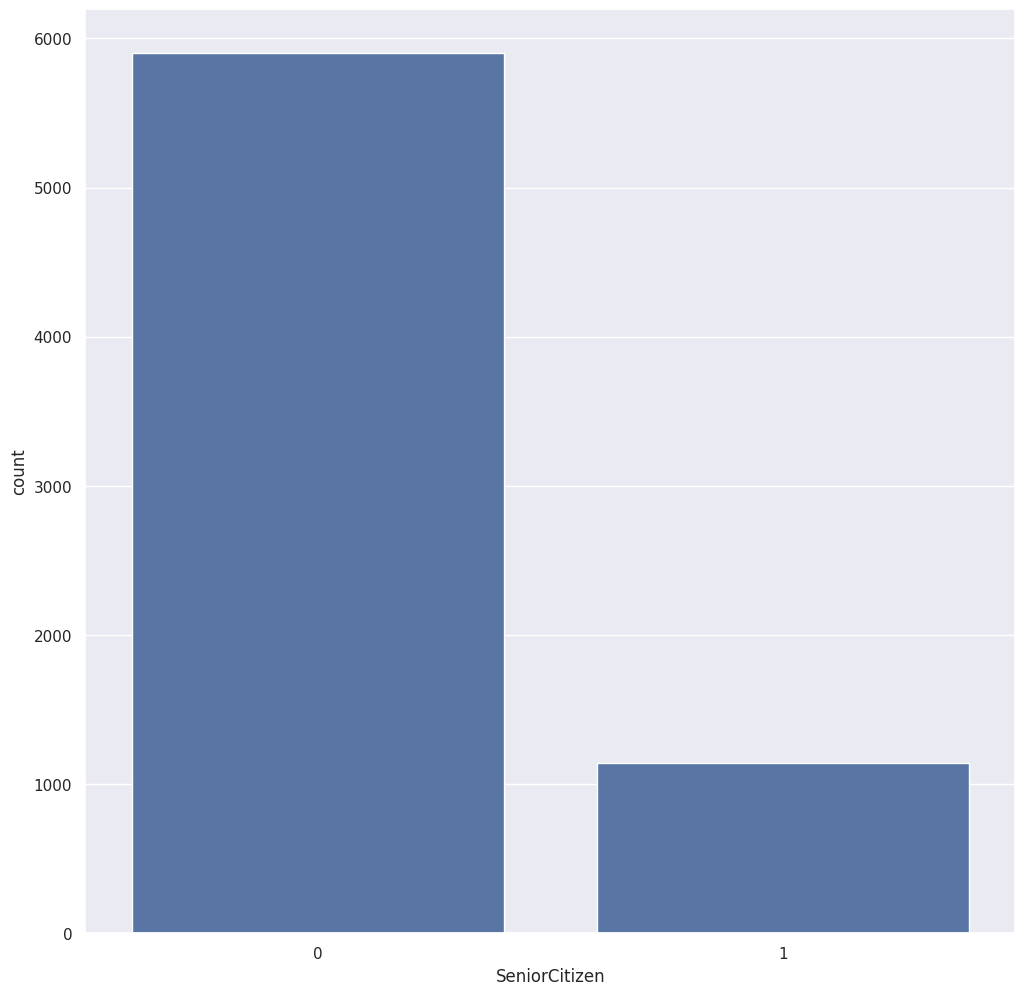

       Churn      Ratio
Churn                  
0       5174  73.463013
1       1869  26.536987
##########################################


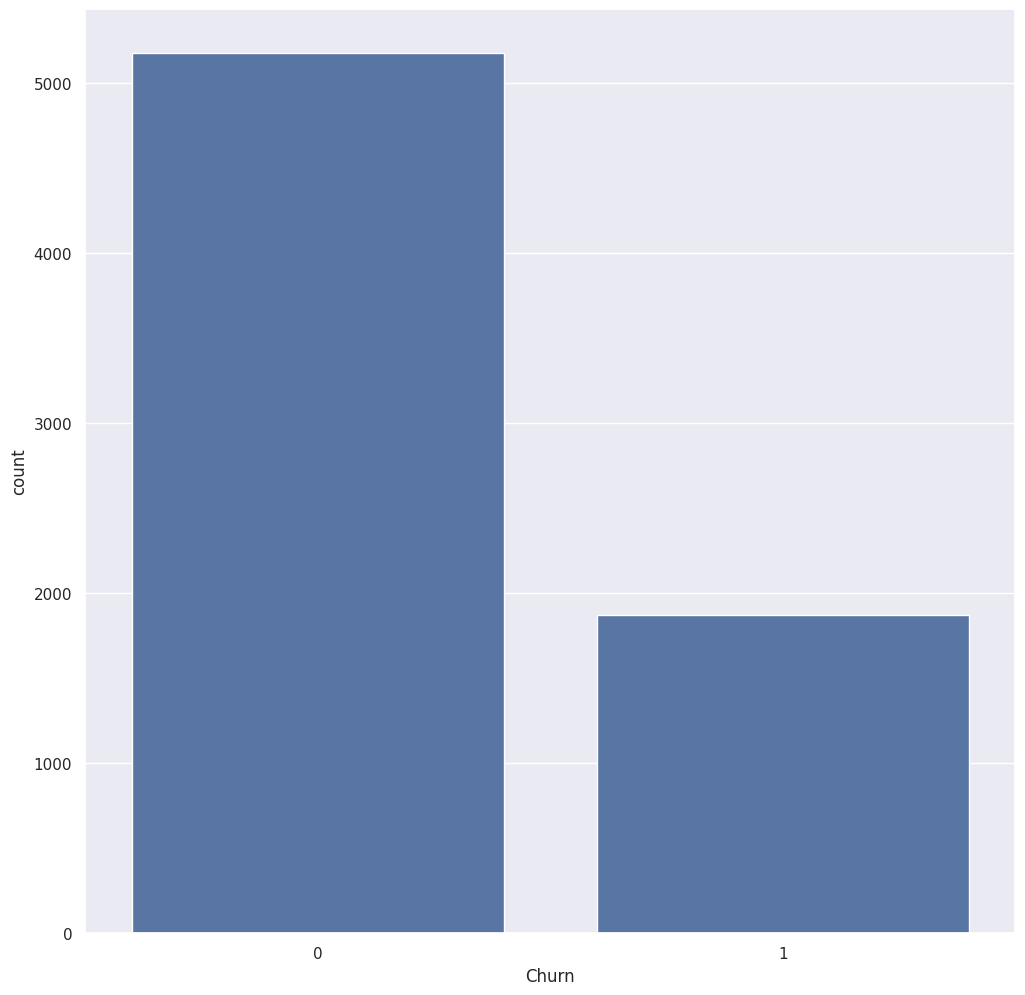

In [255]:
#Kategorik değerler analizi
def cat_summary(dataframe, col_name, plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

  print("##########################################")
  if plot:
      sns.countplot(x=dataframe[col_name], data=dataframe)
      plt.show(block=True)

for col in cat_cols:
  cat_summary(df, col, plot=True)

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64


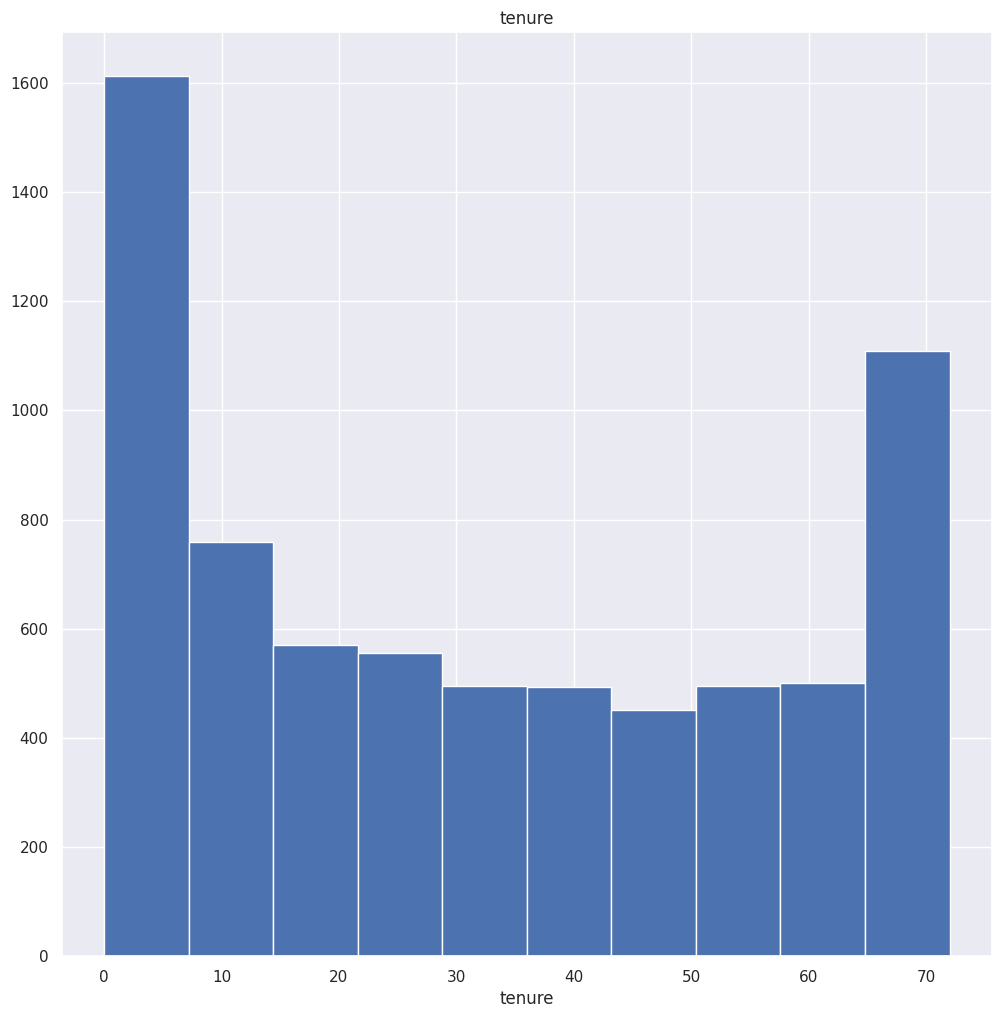

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64


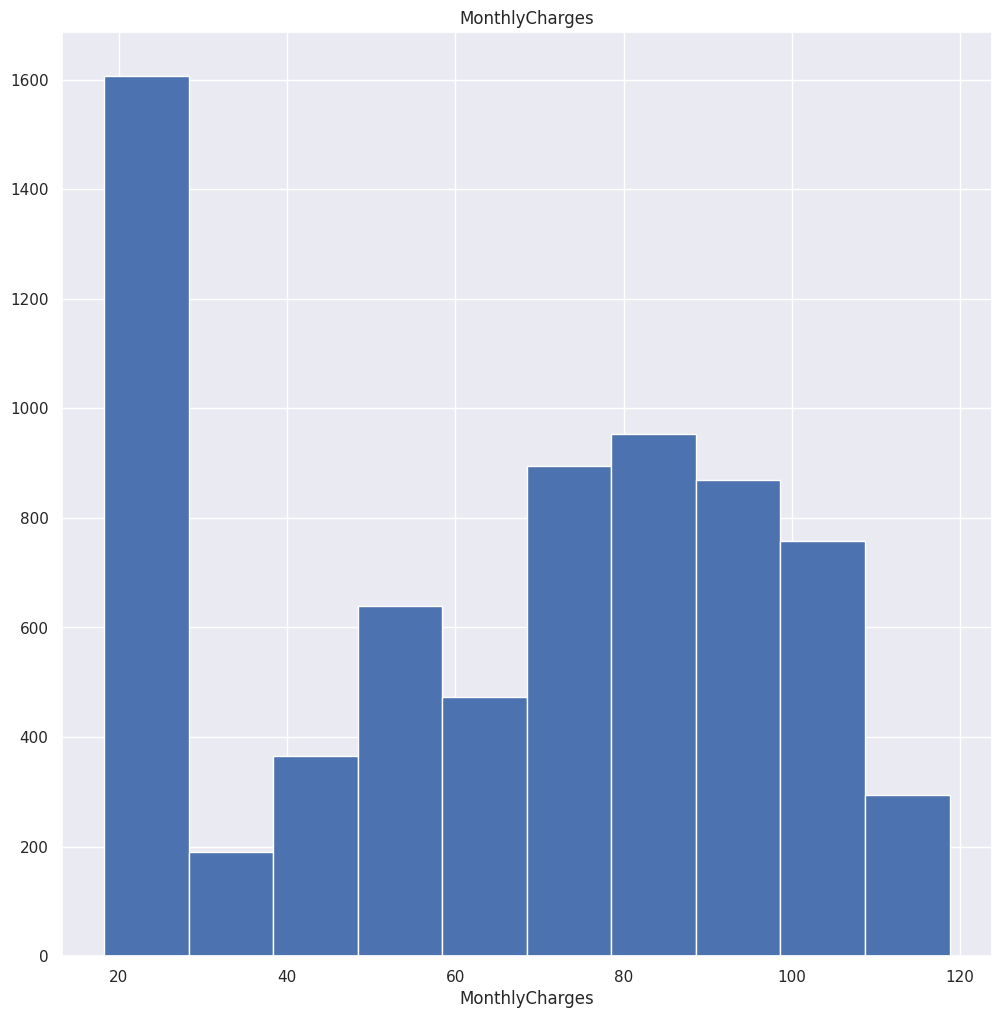

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
5%         49.605000
10%        84.600000
20%       267.070000
30%       551.995000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: TotalCharges, dtype: float64


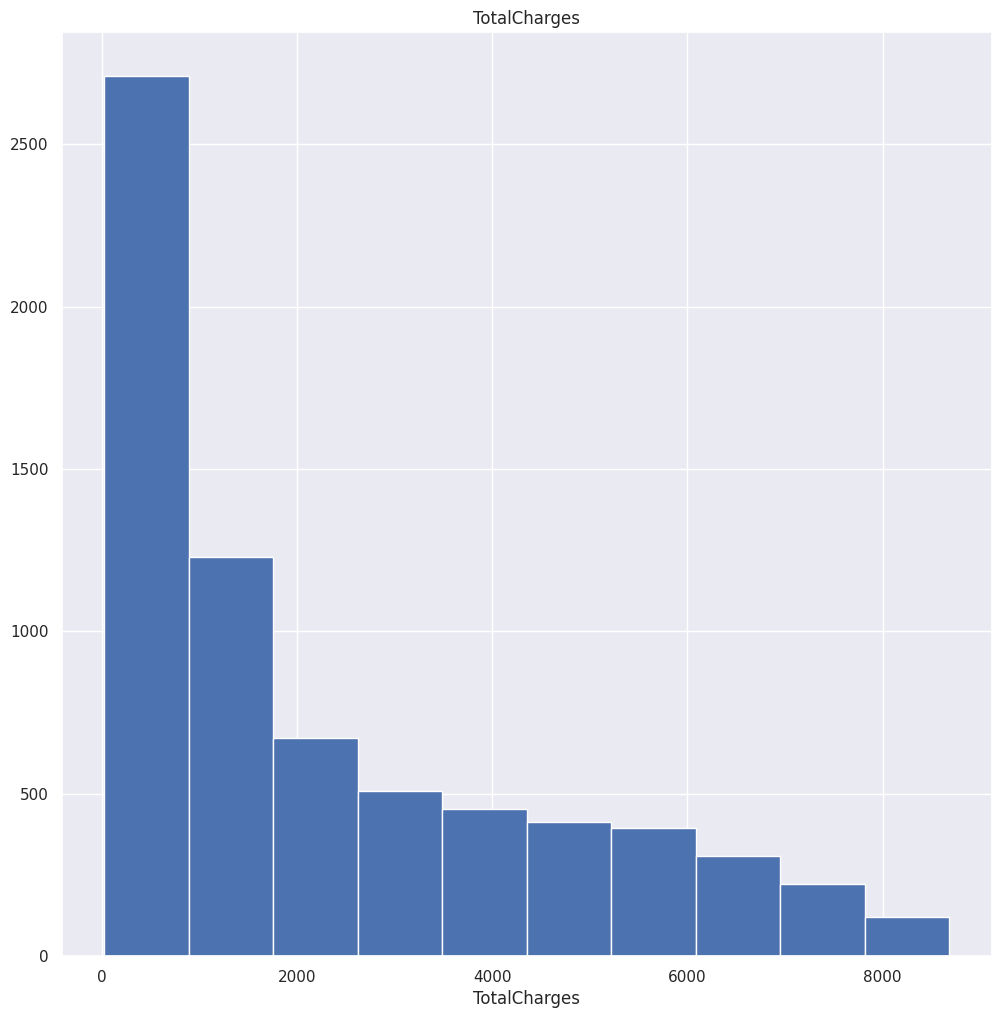

In [256]:
#Numerik değerler analizi
def num_summary(dataframe, numerical_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)

  if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

In [257]:
def target_vs_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


for col in num_cols:
    target_vs_num(df, "Churn", col)

          tenure
Churn           
0      37.569965
1      17.979133


       MonthlyCharges
Churn                
0           61.265124
1           74.441332


       TotalCharges
Churn              
0       2555.344141
1       1531.796094




In [258]:
def target_vs_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_vs_cat(df, "Churn", col)

        TARGET_MEAN  Count     Ratio
gender                              
Female     0.269209   3488  49.52435
Male       0.261603   3555  50.47565


         TARGET_MEAN  Count     Ratio
Partner                              
No          0.329580   3641  51.69672
Yes         0.196649   3402  48.30328


            TARGET_MEAN  Count      Ratio
Dependents                               
No             0.312791   4933  70.041176
Yes            0.154502   2110  29.958824


              TARGET_MEAN  Count      Ratio
PhoneService                               
No               0.249267    682   9.683374
Yes              0.267096   6361  90.316626


                  TARGET_MEAN  Count      Ratio
MultipleLines                                  
No                   0.250442   3390  48.132898
No phone service     0.249267    682   9.683374
Yes                  0.286099   2971  42.183729


                 TARGET_MEAN  Count      Ratio
InternetService                               
DSL         

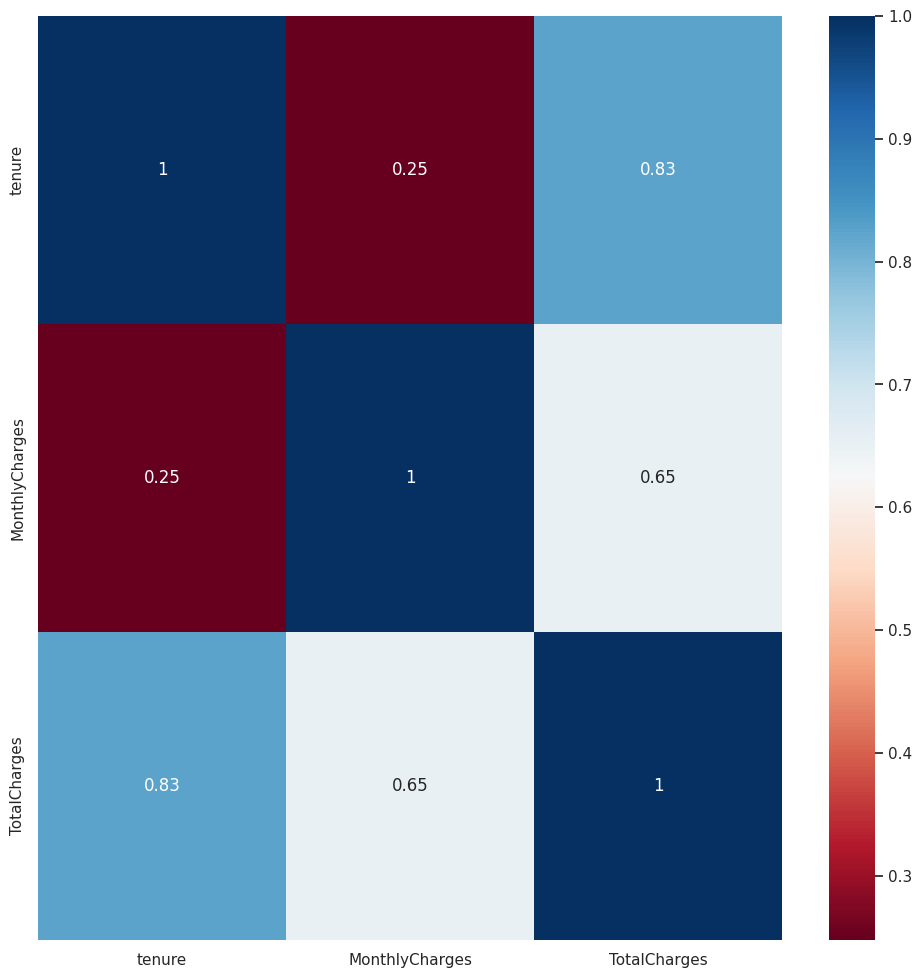

In [259]:
corr = df[num_cols].corr()
sns.set(rc = {"figure.figsize":(12,12)})
sns.heatmap(corr, annot=True, cmap="RdBu")
plt.show()

In [260]:
#Eksik Değer
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [261]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

In [262]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [263]:
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes  

BASE MODEL: Feature engineering yapıldığında nasıl değiştini göstermek için kullanıyoruz.

In [264]:
#İşlemleri önce dff üzerinden değerlendiriyoruz sonrasında df ile yine devam edeceğiz.
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [265]:
#Şimdi base modelden önce one-hot-encoder yapacağız çünkü veri setimizde halen object değerler vardır.
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

dff = one_hot_encoder(dff, cat_cols, drop_first=True)

In [266]:
y = dff["Churn"]
X = dff.drop(["Churn","customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=17)

catboost_model = CatBoostClassifier(verbose=False, random_state=42).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 4)}")
print(f"F1: {round(f1_score(y_pred, y_test), 4)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 4)}")

Accuracy: 0.7928
Recall: 0.6526
Precision: 0.4908
F1: 0.5602
Auc: 0.7405


Df ile devam ediyoruz

In [267]:
#Aykırı değer

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


# Aykırı Değer Analizi ve Baskılama İşlemi
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

tenure False
MonthlyCharges False
TotalCharges False


In [268]:
#Yeni değişkenler
df.loc[(df["tenure"] >= 0) & (df["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 "
df.loc[(df["tenure"] > 12) & (df["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 "
df.loc[(df["tenure"] > 24) & (df["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 "
df.loc[(df["tenure"] > 36) & (df["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 "
df.loc[(df["tenure"] > 48) & (df["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 "
df.loc[(df["tenure"] > 60) & (df["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 "

df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                               'OnlineBackup', 'DeviceProtection', 'TechSupport',
                               'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

df["PaymentMethod"].unique()
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] +0.1)

df["NEW_Increase"] = df["NEW_AVG_Charges"] / (df["MonthlyCharges"] + 1)

df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,0-1,0,1,1,1,0,0,27.136364,0.879623,14.9250
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,2-3,1,1,0,3,0,0,55.410557,0.956179,14.2375
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,0-1,0,1,1,3,0,0,51.500000,0.938924,13.4625
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,3-4,1,1,0,3,0,1,40.814856,0.942606,10.5750
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,0-1,0,1,1,1,0,0,72.214286,1.007173,35.3500


In [269]:
#Encoding işlemlerini yapıyoruz. Grab_col_names'i kullanma amacımız yeni değişkenlerin hangi gruba ait olduğunu belirlemek.
cat_cols,num_cols,cat_but_car = grab_col_names(df)

def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])


binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_cols:
  label_encoder(df, col)

df.head()

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 8


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,...,0-1,0,1,1,1,0,0,27.136364,0.879623,14.9250
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,...,2-3,1,1,0,3,0,0,55.410557,0.956179,14.2375
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,...,0-1,0,1,1,3,0,0,51.500000,0.938924,13.4625
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,...,3-4,1,1,0,3,0,1,40.814856,0.942606,10.5750
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,...,0-1,0,1,1,1,0,0,72.214286,1.007173,35.3500


In [270]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'SeniorCitizen',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [271]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [272]:
#Şimdi final modeli için standartlaştırılma yapılıcak
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,NEW_TENURE_YEAR_2-3,NEW_TENURE_YEAR_3-4,NEW_TENURE_YEAR_4-5,NEW_TENURE_YEAR_5-6,SeniorCitizen_1,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,1,0,-1.277445,0,1,-1.160323,-0.994242,0,...,False,False,False,False,False,False,True,True,False,False
1,5575-GNVDE,1,0,0,0.066327,1,0,-0.259629,-0.173244,0,...,True,False,False,False,False,True,True,False,False,False
2,3668-QPYBK,1,0,0,-1.236724,1,1,-0.362660,-0.959674,1,...,False,False,False,False,False,False,True,True,False,False
3,7795-CFOCW,1,0,0,0.514251,0,0,-0.746535,-0.194766,0,...,False,True,False,False,False,True,True,False,False,True
4,9237-HQITU,0,0,0,-1.236724,1,1,0.197365,-0.940470,1,...,False,False,False,False,False,False,True,True,False,False


In [273]:
#Final modelini oluşturuyoruz.
y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

catboost_model = CatBoostClassifier(verbose=False, random_state=17).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 4)}")
print(f"F1: {round(f1_score(y_pred, y_test), 4)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 4)}")

Accuracy: 0.7906
Recall: 0.6409
Precision: 0.504
F1: 0.5643
Auc: 0.7359
